# Chapter 3. Classification

## Mnist

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)

In [2]:
mnist['data'], mnist['target']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

In [3]:
X, y = mnist['data'], mnist['target'].astype('int')

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

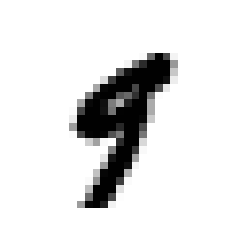

In [6]:
some_digit = X[36000]
plt.imshow(some_digit.reshape(28,28), cmap= matplotlib.cm.binary,
           interpolation='nearest')
plt.axis('off');

In [7]:
y[36000]

9

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Classificator capable of distinguishing between 9 and not-9

In [9]:
y_train_9 = (y_train == 9)

In [10]:
y_test_9 = (y_test == 9)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

In [12]:
%%time
sgd_clf.fit(X_train, y_train_9)

CPU times: user 19.7 s, sys: 111 ms, total: 19.8 s
Wall time: 19.9 s


SGDClassifier(random_state=42)

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring='accuracy')

array([0.9456 , 0.95195, 0.9509 ])

In [14]:
# "Dumb" classifier 
from sklearn.base import BaseEstimator

class Never9Classifier (BaseEstimator):
    def fit(self, X, y=None):
            pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring='accuracy')

array([0.8993 , 0.8999 , 0.90335])

When dealing with skewed datasets (some classes more frequent than others), accuracy is not a good performance measure.

### Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_9, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_9, y_train_pred)

array([[52715,  1336],
       [ 1695,  4254]])

### Precision and Recall

In [18]:
from sklearn.metrics import precision_score, recall_score

In [19]:
precision_score(y_train_9, y_train_pred)

0.7610017889087657

correct only 76% of the time 

In [20]:
recall_score(y_train_9, y_train_pred)

0.7150781643973777

only detects 71% of the 9s

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_9, y_train_pred)

0.737325591472398

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-4440.66086996])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
threshold = 200000

In [25]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3,
                          method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

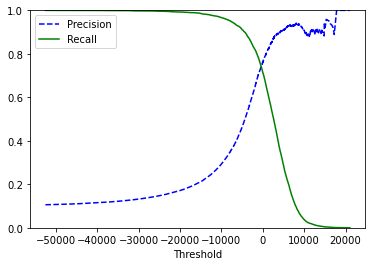

In [29]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [30]:
y_train_pred_90 = (y_scores > 70000)

In [31]:
np.unique(y_train_pred_90)

array([False])

In [32]:
precision_score(y_train_9, y_train_pred_90)

/home/adrian/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [33]:
recall_score(y_train_9, y_train_pred_90)

0.0

### ROC Curve

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

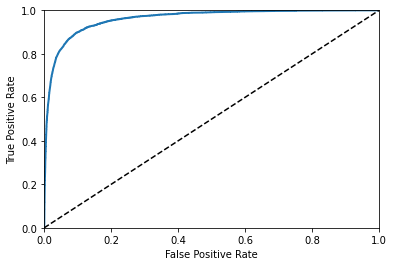

In [36]:
plot_roc_curve(fpr, tpr);

In [37]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_9, y_scores)

0.96114559368217

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [39]:
%%time
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3,
                                   method="predict_proba")

CPU times: user 52 s, sys: 240 ms, total: 52.3 s
Wall time: 52.4 s


In [40]:
y_scores_forest = y_probas_forest[:, 1] # positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

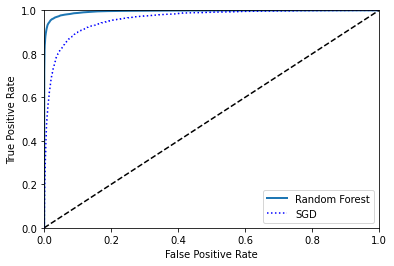

In [41]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "b:", label='SGD')
plt.legend(loc="lower right");

In [42]:
roc_auc_score(y_train_9, y_scores_forest)

0.9952328942154235

In [43]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3)

In [44]:
precision_score(y_train_9, y_train_pred_forest)

0.9819324430479183

In [45]:
recall_score(y_train_9, y_train_pred_forest)

0.8404773911581779

## Multiclass Classification

In [46]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [47]:
sgd_clf.predict([some_digit])

array([3])

In [48]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-42309.24702339, -24514.78707295, -21802.99686514,
          -253.56670849,  -6692.29918582,  -5022.40064344,
        -34623.10033652,  -8392.84727568,  -3181.89959952,
         -2356.71582334]])

In [49]:
np.argmax(some_digit_scores)

3

In [50]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [51]:
%%time
forest_clf.fit(X_train, y_train)

CPU times: user 38.7 s, sys: 79.9 ms, total: 38.7 s
Wall time: 38.8 s


RandomForestClassifier(random_state=42)

In [52]:
forest_clf.predict([some_digit])

array([9])

In [53]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.01, 0.  , 0.01, 0.15, 0.  , 0.  , 0.04, 0.  , 0.79]])

In [55]:
%%time
#cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11 µs


In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
#cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

## Error Analysis

In [59]:
%%time
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=7)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

CPU times: user 168 ms, sys: 348 ms, total: 516 ms
Wall time: 4min 31s


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

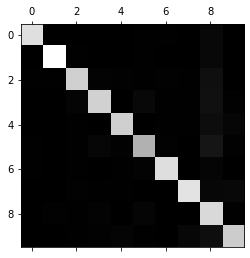

In [60]:
plt.matshow(conf_mx, cmap=plt.cm.gray);

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

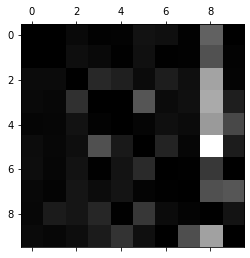

In [62]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray);

In [63]:
cl_a, cl_b = 3, 5

In [64]:
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]

In [68]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

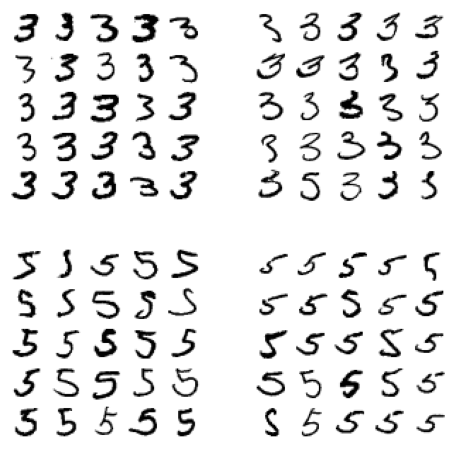

In [69]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

## Exercises

### 1.

In [71]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'weights': ["uniform", "distance"], 
    'n_neighbors': [3, 4, 5]
}]

grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
